In [1]:
#Distributions and Modules
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import distributions
import pandas as pd
import numpy as np
from torch import optim
import matplotlib.pyplot as plt
import random, math
import copy
import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Import CMAPSS Dataset

In [51]:
df = pd.read_csv("train_FD001.csv") #gamma = 0.9
df = df.drop(columns=["Unnamed: 0"])
df.head(5)

,machine,time,2,3,6,7,8,9,10,11,...,16,17,18,19,20,21,24,25,reward,MC_Val
0,1,1,-0.315972,-1.372920,-1.721684,-0.134252,-0.925914,-0.999976,0.14168,1.121113,...,0.334254,-1.058865,-0.269065,-0.603801,-0.999976,-0.781691,1.348460,1.194398,0,-1.821039e-07
1,1,2,0.872701,-1.031695,-1.061754,0.211523,-0.643710,-0.999976,0.14168,0.431920,...,1.174871,-0.363637,-0.642829,-0.275845,-0.999976,-0.781691,1.016503,1.236892,0,-2.023377e-07
2,1,3,-1.961827,1.015652,-0.661797,-0.413156,-0.525940,-0.999976,0.14168,1.008131,...,1.364688,-0.919819,-0.551616,-0.649128,-0.999976,-2.073044,0.739873,0.503411,0,-2.248197e-07
3,1,4,0.324083,-0.008022,-0.661797,-1.261284,-0.784812,-0.999976,0.14168,1.222798,...,1.961255,-0.224592,-0.520163,-1.971617,-0.999976,-0.781691,0.352590,0.777773,0,-2.497996e-07
4,1,5,-0.864590,-0.690471,-0.621801,-1.251498,-0.301511,-0.999976,0.14168,0.714376,...,1.052846,-0.780774,-0.521736,-0.339837,-0.999976,-0.136014,0.463242,1.059526,0,-2.775551e-07


In [3]:
healthy_start_indices = np.array(list(df[df["time"] == 1].index))
healthy_start_indices

array([    0,   192,   479,   658,   847,  1116,  1304,  1563,  1713,
        1914,  2136,  2376,  2546,  2709,  2889,  3096,  3305,  3581,
        3776,  3934,  4168,  4363,  4565,  4733,  4880,  5110,  5309,
        5465,  5630,  5793,  5987,  6221,  6412,  6612,  6807,  6988,
        7146,  7316,  7510,  7638,  7826,  8042,  8238,  8445,  8637,
        8795,  9051,  9265,  9496,  9711,  9909, 10122, 10335, 10530,
       10787, 10980, 11255, 11392, 11539, 11770, 11942, 12127, 12307,
       12481, 12764, 12917, 13119, 13432, 13631, 13993, 14130, 14338,
       14551, 14764, 14930, 15159, 15369, 15523, 15754, 15953, 16138,
       16378, 16592, 16885, 17152, 17340, 17618, 17796, 18009, 18226,
       18380, 18515, 18856, 19011, 19269, 19552, 19888, 20090, 20246,
       20431])

# Neural Networks for Predictron

In [4]:
#Neural network for Observation - Hidden State

class NN_OH(nn.Module):
    def __init__(self, input_size, out_size):
        super(NN_OH,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,out_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [5]:
#Neural network for Hidden State - Reward, Gamma, Lambda

class NN_reward(nn.Module):
    def __init__(self, input_size):
        super(NN_reward,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,3)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # constrain gamma and lambda to be between 0 and 1 with sigmoid
        x[:, 1:3] = torch.sigmoid(x[:, 1:3])
        return x

In [6]:
#Neural network for Hidden State - Value
class NN_val(nn.Module):
    def __init__(self, input_size):
        super(NN_val,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
transition_matrix = torch.Tensor([[0.347, 0.653, 0.0, 0.0], 
                                     [0.0, 0.652, 0.348, 0.0],
                                     [0.0, 0.0, 0.505, 0.495],
                                     [0.0, 0.0, 0.0, 1.0]])
transition_matrix

tensor([[0.3470, 0.6530, 0.0000, 0.0000],
        [0.0000, 0.6520, 0.3480, 0.0000],
        [0.0000, 0.0000, 0.5050, 0.4950],
        [0.0000, 0.0000, 0.0000, 1.0000]])

In [8]:
# take my current hidden state to the next hidden state
def NN_HH(hidden_state):
    
    # hidden_state is a tensor of shape [*, 4]
    
    transposed_states = torch.transpose(hidden_state, 0, 1)
    return torch.transpose(torch.matmul(transition_matrix, transposed_states), 0, 1)
  

# Predictron

In [9]:
#Now we have all the required neural networks for the predictron. Lets build the Predictron

class Predictronv4(nn.Module):
    def __init__(self, obs_size, hid_size, k=10):
        super(Predictronv4,self).__init__()
        
        #Instantiate Neural Network for Observation-Hidden State
        self.OH = NN_OH(obs_size, hid_size)
        
        #Instantiate Neural Network for Hidden State - Reward, Value
        self.HR = NN_reward(hid_size)
        
        #Instantiate Neural Network for Hidden State - Val
        self.HV = NN_val(hid_size)
        
        #K-step return
        self.k = k
        
    def forward(self, x, isHidden=False):
        """
        
        isHidden - False if x is an observation vector
        
        """
        #First step: Get the Hidden state for the current observation
        if isHidden == False:
            x = self.OH(x)
        
        # Initialize lists
        rewards = []
        gammas = []
        lambdas = []
        values = []
        
        # forward pass
        for k in range(0, self.k + 1):
            
            rewards.append(self.HR(x)[:, 0].reshape(-1, 1))
            gammas.append(self.HR(x)[:, 1].reshape(-1, 1))
            lambdas.append(self.HR(x)[:, 2].reshape(-1, 1))
            values.append(self.HV(x))
            
            #get the next hidden state
            x = NN_HH(x)

        # backwards pass to compute g-lambda
        gl = values[self.k]
        for k in range(0, self.k)[::-1]:
            gl = ((1 - lambdas[k])*values[k]) + (lambdas[k] * (rewards[k+1] + (gammas[k+1]*gl)))
        
        return gl.reshape(-1, 1)

In [10]:
def getXY(data):
    x = torch.tensor(data.iloc[:, 2:-2].values).float()
    y_target = torch.tensor(data.iloc[:,-1].values).float()
    y_target = y_target.reshape(-1,1)
    
    return x, y_target

In [11]:
x, y_target = getXY(df)

In [12]:
# Load Predictron with k=10
k = 10
predictron = Predictronv4(x.shape[1], 4, k)
predictron.OH.load_state_dict(torch.load("OH_training_FD001_k10.pth"))
predictron.HR.load_state_dict(torch.load("HR_training_FD001_k10.pth"))
predictron.HV.load_state_dict(torch.load("HV_training_FD001_k10.pth"))


<All keys matched successfully>

In [13]:
# Freeze observation to hidden state neural net
for param in predictron.OH.parameters():
    param.requires_grad = False

# DQN

In [14]:
class Brain:
    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.model = self._createModel()

    def _createModel(self):
        model = Sequential()
        model.add(keras.Input(shape=(self.stateCnt,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.actionCnt, activation='linear'))

        opt = RMSprop(lr=0.0025)
        model.compile(loss='mse', optimizer=opt)

        return model

    def train(self, x, y, verbose=0):
        """
        Performs a gradient descent step with given batch
        """
        self.model.fit(x, y, batch_size=x.shape[0], verbose=verbose)

    def predict(self, s):
        """
        Predicts the Q function values
        """
        if type(s) is torch.Tensor:
            s = s.detach().numpy()
        return self.model.predict(s)

    def predictOne(self, s):
        if type(s) is torch.Tensor:
            s = s.detach().numpy()
        return self.predict(s.reshape(1, self.stateCnt)).flatten()

In [15]:
class Environment:
    
    def __init__(self):
        return

    def step(self, s, a):
        """
        Given action a and current hidden state s, 
        returns a new hidden state, reward, and done indicator
        
        """
        done = False
        
        # if the action is to repair, the next state is a random healthy start state
        # otherwise, ask the predictron for the next state
        
        #s_ = torch.tensor([1, 0, 0, 0]).float().reshape(-1, 4)
        
        # randomly sample a healthy observation from training dataset
        s_ = x[np.random.choice(healthy_start_indices, 1)[0], :]
            
        #get corresponding hidden state
        s_ = predictron.OH(s_).float().reshape(-1, 4)
        
        
        if a == 0:
            #s_ = predictron.HH(s).reshape(-1, 4)
            s_ = NN_HH(s).reshape(-1, 4)
            health_s_ = torch.argmax(s_).item()

            # if the next state's health is 3
            if (health_s_ == 3):
                done = True
                
        # compute reward
        reward = 0
        for state in range(1, 5):
            reward += (50 * (4 - state) * s[:, state - 1].item()) + (-50 * state * a)
        
        return s_, reward, done
    
    def run(self, agent, T, M):
        """
        T: timesteps per episode
        M: number of episodes
        """
        
        for e in range(0, M):
            
            #s = torch.tensor([1, 0, 0, 0]).float().reshape(-1, 4)
            
            # randomly sample a healthy observation from training dataset
            s = x[np.random.choice(healthy_start_indices, 1)[0], :]
            
            #get corresponding hidden state
            s = predictron.OH(s).float().reshape(-1, 4)
            
            
            reward_accum = 0
        
            for t in range(0, T):           

                a = agent.act(s) #decide which action to take

                # environment performs this action and returns a new state and reward
                s_, r, done = self.step(s, a) 
                reward_accum += r

                agent.observe( (s, a, reward_accum, s_) ) 
                agent.replay()             

                s = s_

                if done:
                    break

In [16]:
class Memory:   # stored as ( s, a, r, s_ )

    def __init__(self, capacity):
        self.capacity = capacity
        self.samples = []

    def add(self, sample):
        """
        stores the experience into self.samples, 
        ensuring it doesn't exceed its capacity
        """
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def sample(self, n):
        """
        returns n random samples from memory
        """
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

In [17]:
MEMORY_CAPACITY = 50
BATCH_SIZE = 10

GAMMA = 0.7

MAX_EPSILON = 0.9
MIN_EPSILON = 0.01
LAMBDA = 0.001      # speed of decay

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, stateCnt, actionCnt):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)
        
    def act(self, s, greedy=False):
        """
        With epsilon probability, chooses a random action, otherwise
        selects the best action with the current Q
        """
        if greedy:
            return np.argmax(self.brain.predictOne(s))
        
        if random.random() < self.epsilon:
            return random.randint(0, self.actionCnt-1)
        else:
            return np.argmax(self.brain.predictOne(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add(sample)        

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def replay(self):    
        # fetch a batch of random samples from memory
        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        states = np.array([ o[0].detach().numpy() for o in batch ])
        states_ = np.array([ o[3].detach().numpy() for o in batch ])
 
        p = self.brain.predict(states)
        p = [x[0] for x in p]

        x = np.zeros((batchLen, self.stateCnt))
        y = np.zeros((batchLen, self.actionCnt))
        
        for i in range(batchLen):
            o = batch[i]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]

            t = p[i] #q value
            if torch.argmax(s_).item() == 3:
                t[a] = r
            else:
                t[a] = r + GAMMA * predictron.forward(s_, True)

            x[i] = s.detach().numpy()
            y[i] = t

        self.brain.train(x, y)

# Integration of DQN and Predictron

`permutations` is a list of 13 hidden states used to test for convergence while the algorithm is running. Denote these states $s_i$ for $i \in \{1, 2, ... 13\}$.

Two types of errors are computed during each iteration:

(1) `Q-Value Norm Error`: Let $v_{i} = max_{a \in \{0, 1\}}Q(s_i, a)$ and $\hat{v}_{i} = max_{a \in \{0, 1\}}Q(s_i, a)$ be the q-values that correspond to the optimal actions for each of the hidden states before and after the update with the Predictron is performed (respectively). The q-value norm error is $\sqrt{\sum_{i = 1}^{13}(\hat{v}_{i} - v_i)^{2}}$.



(2) `Action Error`: Let $a_{i} = argmax_{a} Q(s_i, a)$ and $\hat{a}_{i} = argmax_{a} Q(s_i, a)$ be the actions that yield the largest q-values for each of the hidden states before and after the update with the Predictron is performed (respectively). The action error is $\sum_{i = 1}^{13} |a_{i} - \hat{a}_{i}|$. With 13 states, this error can be between 0 and 13.

Plots of these errors over 50 iterations are shown below.

In [18]:
permutations = [np.array([1, 0, 0, 0]), np.array([0, 1, 0, 0]), 
                np.array([0, 0, 1, 0]), np.array([0, 0, 0, 1]),
               np.array([0.5, 0.5, 0, 0]), np.array([0, 0.5, 0.5, 0]), 
                np.array([0, 0, 0.5, 0.5]), np.array([0.3, 0.7, 0, 0]), 
                np.array([0, 0.3, 0.7, 0]), np.array([0, 0, 0.3, 0.7]),
               np.array([0.7, 0.3, 0, 0]), np.array([0, 0.7, 0.3, 0]), 
                np.array([0, 0, 0.7, 0.3])]
test_permutations = [torch.tensor(p).float().reshape(-1, 4) for p in permutations]

loss_fn = nn.MSELoss()
optimizer = optim.Adam(predictron.parameters(), lr = 1e-3) 

In [19]:
stateCnt = 4
actionCnt = 2

agent = Agent(stateCnt, actionCnt)
env = Environment()

j = 3
l = 10

timesteps = 10
episodes = 10

initial_iter = True
errors = []
action_errors = []

for i in range(0, 51):
    #print("iteration " + str(i))
    q_values = []
    
    if initial_iter == False:
        
        # Check for convergence by checking Q values of hidden states before update
        for p in test_permutations:
            
            q_values.append(agent.brain.predict(p))
            
            
    # Update Q using trained Predictron. Repeat j times
    for s in range(0, j):
        env.run(agent, timesteps, episodes)

    # Check for convergence
    if initial_iter == False:
        norm_error = 0
        action_error = 0
        for r in range(0, len(test_permutations)):

            p = test_permutations[r]
            old_q = q_values[r][0]
            updated_q = agent.brain.predict(p)[0]

            action_error += abs(np.argmax(old_q) - np.argmax(updated_q))
            norm_error += (max(old_q) - max(updated_q)) ** 2

        norm_error = np.sqrt(norm_error)
        #print(norm_error)
        #print(action_error)
        action_errors.append(action_error)
        errors.append(norm_error)
    
    # if at final iteration, break
    if i == 50:
        break

    # collect l trajectories using Q
    states = []
    q_values = []
    for v in range(0, l):
        #curr = torch.tensor([1, 0, 0, 0]).float().reshape(-1, 4)
        
        # randomly sample a healthy observation from training dataset
        curr = x[np.random.choice(healthy_start_indices, 1)[0], :]
        #get corresponding hidden state
        curr = predictron.OH(curr).float().reshape(-1, 4)
        
        done_ = False
        for t in range(0, timesteps):
            
            # get next action
            action = agent.act(curr, True)
            # get q-value of action
            q_value = agent.brain.predict(curr)[0][action]

            states.append(curr.detach().numpy())
            q_values.append(q_value)

            if done_:
                break
            
            # update curr to next state
            curr, r, done = env.step(curr, action)
                
            # update done_
            done_ = done
            
    
    # Update the Predictron using new trajectories

    outputs = predictron.forward(torch.tensor(states).float().reshape(-1, 4), True)
    loss = loss_fn(outputs, torch.tensor(q_values).float().reshape(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    
    if initial_iter == True:
        initial_iter = False

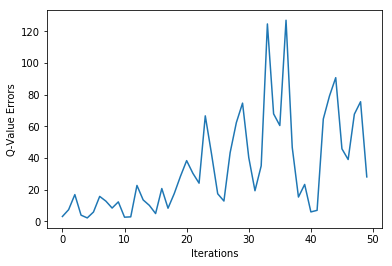

In [20]:
# Plot Errors
plt.plot(errors)
plt.xlabel("Iterations")
plt.ylabel("Q-Value Errors")
plt.show()

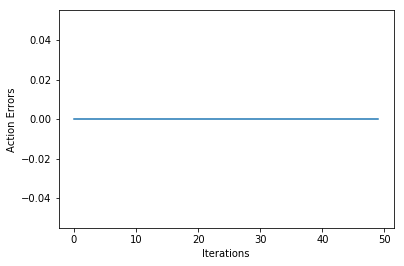

In [21]:
# Plot Action Errors
plt.plot(action_errors)
plt.xlabel("Iterations")
plt.ylabel("Action Errors")
plt.show()

In [22]:
# save models
torch.save(predictron.state_dict(), "Predictron_dqn_k10.pth")
agent.brain.model.save("Q_function_k10.pth")

## Final Convergence Test

rand is a list of 1000 randomly generated hidden states. As a final test for convergence, the trained models are reloaded, and one iteration of the previous algorithm is performed. Running this portion several times yielded similar results; approximately 5-6 percent of the 1000 hidden states had different optimal actions after the update.

In [26]:
rand = [np.random.choice(10, 4) for i in range(0, 1000)]
rand = [lst/sum(lst) for lst in rand]
rand_permutations = [torch.tensor(p).float().reshape(-1, 4) for p in rand]

In [27]:
predictron = Predictronv4(x.shape[1], 4, 10)
predictron.load_state_dict(torch.load("Predictron_dqn_k10.pth"))
agent = Agent(4, 2)
agent.brain.model = keras.models.load_model('Q_function_k10.pth')

In [28]:
# collect l trajectories using Q
states = []
q_values = []
for i in range(0, l):
    #curr = torch.tensor([1, 0, 0, 0]).float().reshape(-1, 4)
    
    # randomly sample a healthy observation from training dataset
    curr = x[np.random.choice(healthy_start_indices, 1)[0], :]
    #get corresponding hidden state
    curr = predictron.OH(curr).float().reshape(-1, 4)
    
    done_ = False
    for t in range(0, timesteps):
            
        # get next action
        action = agent.act(curr, True)
        # get q-value of action
        q_value = agent.brain.predict(curr)[0][action]

        states.append(curr.detach().numpy())
        q_values.append(q_value)

        if done_:
            break
            
        # update curr to next state
        curr, r, done = env.step(curr, action)
                
        # update done_
        done_ = done
            
    
# Update the Predictron using new trajectories

outputs = predictron.forward(torch.tensor(states).float().reshape(-1, 4), True)
loss = loss_fn(outputs, torch.tensor(q_values).float().reshape(-1, 1))
optimizer.zero_grad()
loss.backward()
optimizer.step()
    
    
    
q_values = []
    
        
# Check for convergence by checking Q values of hidden states before update
for p in rand_permutations:
            
    q_values.append(agent.brain.predict(p))
            
            
# Update Q using trained Predictron. Repeat j times
for i in range(0, j):
    env.run(agent, timesteps, episodes)

# Check for convergence
action_error = 0
for i in range(0, len(rand_permutations)):

    p = rand_permutations[i]
    old_q = q_values[i][0]
    updated_q = agent.brain.predict(p)[0]

    action_error += abs(np.argmax(old_q) - np.argmax(updated_q))

print(str((action_error/1000)* 100) + " percent of the 1000 randomly generated hidden states had updated optimal actions")


0.0 percent of the 1000 randomly generated hidden states had updated optimal actions


## Correctness Checks

In [31]:
predictron = Predictronv4(x.shape[1], 4, 10)
predictron.load_state_dict(torch.load("Predictron_dqn_k10.pth"))
agent = Agent(4, 2)
agent.brain.model = keras.models.load_model('Q_function_k10.pth')

In [32]:
# Check that the optimal action for healthy states is continuing (not repairing)
health_errors = 0
for idx in healthy_start_indices:
    
    curr = x[idx, :] #observation
    curr = predictron.OH(curr).float().reshape(-1, 4) # hiddent state
    
    action = agent.act(curr, True) # get next action
    if action != 0:
        health_errors += 1

print("start error: " + str(health_errors / len(healthy_start_indices)))
    


start error: 0.0


In [125]:
# Check that the optimal action for unhealthy states is repairing
unhealthy_errors = 0
unhealthiest_tuples = df.groupby('machine').last()[['time']]

for machine, time in unhealthiest_tuples.iterrows():
    temp = df[df["machine"] == machine]
    idx = temp[temp['time'] == time["time"]].index[0]
    
    curr = x[idx, :] #observation
    curr = predictron.OH(curr).float().reshape(-1, 4) # hidden state
    
    action = agent.act(curr, True) # get next action
    
    if action != 1:
        unhealthy_errors += 1

print("end error: " + str(unhealthy_errors/len(unhealthiest_tuples)))

end error: 0.01


In [126]:
def compute_reward(s, a):
    
    """
    s: hidden state
    """
    
    # compute reward
    reward = 0
    for state in range(1, 5):
        reward += (50 * (4 - state) * s[:, state - 1].item()) + (-50 * state * a)
     
    return reward

def compute_reward_tensor(s, a):
    """
    s: tensor of hidden states
    """
    total_reward = 0
    for state in s:
        total_reward += compute_reward(state.float().reshape(-1, 4), 0)
    return total_reward

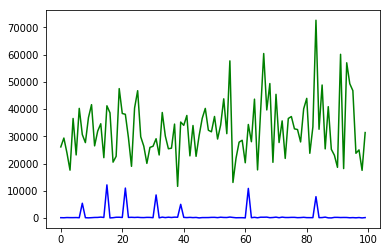

In [127]:
#for each of the states in a training trajectory, 
#convert the state/observation to a hidden state 
#and compute the accumnulated reward

unhealthiest_tuples.reset_index(inplace=True)
trajectory_rewards = []
sampled_rewards = []
for idx in range(0, len(set(df['machine']))):
    
    # compute reward of training trajectory
    
    start_index = healthy_start_indices[idx]
    t = unhealthiest_tuples.iloc[idx]
    temp = df[df["machine"] == t["machine"]]
    end_index = temp[temp["time"] == t["time"]].index[0]
    
    curr = x[start_index:end_index + 1, :] #observations
    curr = predictron.OH(curr).float().reshape(-1, 4)
    #reward = predictron.HR(curr)[:, 0]

    trajectory_rewards.append(compute_reward_tensor(curr, 0))
    
    # compute reward of DQN trajectory from same start state
    
    currState = x[start_index, :] 
    currState = predictron.OH(currState).float().reshape(-1, 4)
    
    done_ = False
    sampled_reward = 0
    
    for t in range(start_index, end_index + 1):
        
        #get next action
        action = agent.act(currState, True) # get next action
        
        if done_:
            break
        # accumulate reward
        #sampled_reward += sum(predictron.HR(currState)[:, 0]).item()
        # update currState to next state
        currState, r, done = env.step(currState, action)
        sampled_reward += r
        
        #update done_
        done_ = done
    sampled_rewards.append(sampled_reward)
    


    
plt.plot(sampled_rewards, label="sampled rewards", color="blue")
plt.plot(trajectory_rewards, label="trajectory rewards", color="green")
plt.show()

# Import test set

In [135]:
test_df = pd.read_csv("test_FD001.csv")
test_df = test_df.drop(columns=["Unnamed: 0", "14"])
test_df.head(5)

,machine,time,2,3,6,7,8,9,10,11,...,16,17,18,19,20,21,24,25,reward,MC_Val
0,1,1,1.049255,1.005889,1.359224,-0.561473,-0.975637,-0.999962,0.175653,0.209130,...,-0.049540,-0.720563,-1.314981,-0.711632,-0.999962,-0.463388,-0.229400,0.448849,0,-4.239116
1,1,2,-1.220702,-1.034715,-1.908429,0.070113,-1.392783,-0.999962,0.175653,1.603551,...,0.736699,-0.193640,0.065974,-1.569977,-0.999962,0.347263,0.899900,0.664017,0,-4.710129
2,1,3,0.141273,0.325687,-0.037635,-0.231689,-0.507656,-0.999962,0.175653,0.517370,...,0.397187,-0.720563,-0.868403,0.629316,-0.999962,0.347263,1.323387,0.961211,0,-5.233476
3,1,4,1.911839,-0.014413,-0.087523,-0.795320,0.251878,-0.999962,0.175653,0.458658,...,-0.657087,-0.369281,-0.593586,-1.177000,-0.999962,-1.274039,0.758737,0.451227,0,-5.814974
4,1,5,0.640663,-0.014413,0.087085,-0.181722,-0.420938,-0.999962,0.175653,0.590761,...,0.718830,-0.720563,-0.923367,-0.784023,-0.999962,-2.084690,0.688156,0.918415,0,-6.461082


In [136]:
x_test, y_test = getXY(test_df)

In [137]:
test_healthy_indices = np.array(list(test_df[test_df["time"] == 1].index))
test_healthy_indices

array([    0,    31,    80,   206,   312,   410,   515,   675,   841,
         896,  1088,  1171,  1388,  1583,  1629,  1705,  1818,  1983,
        2116,  2251,  2435,  2583,  2622,  2752,  2938,  2986,  3062,
        3202,  3360,  3531,  3674,  3870,  4015,  4065,  4268,  4466,
        4592,  4713,  4838,  4875,  5008,  5131,  5287,  5459,  5513,
        5665,  5811,  5884,  5962,  6265,  6339,  6483,  6672,  6836,
        6957,  7070,  7206,  7366,  7542,  7636,  7783,  7942,  8174,
        8329,  8497,  8568,  8715,  8786,  8973,  9027,  9179,  9247,
        9378,  9490,  9627,  9715,  9920, 10082, 10154, 10255, 10388,
       10601, 10763, 10836, 11008, 11042, 11152, 11208, 11276, 11453,
       11599, 11833, 11983, 12227, 12360, 12449, 12546, 12680, 12801,
       12898])

In [138]:
end_tuples = test_df.groupby('machine').last()[['time']]
end_tuples.reset_index(inplace=True)
end_tuples

,machine,time
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98
5,6,105
6,7,160
7,8,166
8,9,55
9,10,192


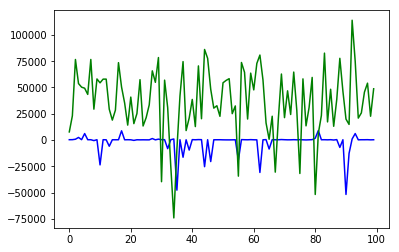

In [139]:
test_trajectory_rewards = []
test_sampled_rewards = []
for idx in range(0, len(test_healthy_indices)):
    
    # compute reward of test trajectory
    
    start_index = test_healthy_indices[idx]
    temp = test_df[test_df["machine"] == end_tuples.iloc[idx]["machine"]]
    end_index = temp[temp["time"] == end_tuples.iloc[idx]["time"]].index[0]
    
    curr = x_test[start_index: end_index + 1, :] #observations
    curr = predictron.OH(curr).float().reshape(-1, 4)
    #reward = predictron.HR(curr)[:, 0]

    test_trajectory_rewards.append(compute_reward_tensor(curr, 0))
    
    # compute reward of DQN trajectory from same start state
    
    currState = x_test[start_index, :] 
    currState = predictron.OH(currState).float().reshape(-1, 4)
    
    done_ = False
    sampled_reward = 0
    
    for t in range(start_index, end_index + 1):
        
        #get next action
        action = agent.act(currState, True) # get next action
        
        if done_:
            break
        # accumulate reward
        #sampled_reward += sum(predictron.HR(currState)[:, 0]).item()
        # update currState to next state
        currState, r, done = env.step(currState, action)
        sampled_reward += r
        
        #update done_
        done_ = done
    test_sampled_rewards.append(sampled_reward)
    


    
plt.plot(test_sampled_rewards, label="sampled rewards", color="blue")
plt.plot(test_trajectory_rewards, label="trajectory rewards", color="green")
plt.show()